#Project: CCPP Energy Output Prediction

This project uses Machine Learning (Random Forests) to predict the energy generation based on environmental sensors of a Combined Cycle Power Plant.

Data Source: The dataset used in this project is the Combined Cycle Power Plant Data Set, publicly available at the UCI Machine Learning Repository.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

 ## 1. Data Loading & Quality Check

In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
combined_cycle_power_plant = fetch_ucirepo(id=294)

# data (as pandas dataframes)
X = combined_cycle_power_plant.data.features
y = combined_cycle_power_plant.data.targets

# metadata
print(combined_cycle_power_plant.metadata)

# variable information
print(combined_cycle_power_plant.variables)


{'uci_id': 294, 'name': 'Combined Cycle Power Plant', 'repository_url': 'https://archive.ics.uci.edu/dataset/294/combined+cycle+power+plant', 'data_url': 'https://archive.ics.uci.edu/static/public/294/data.csv', 'abstract': 'The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the plant was set to work with full load. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 9568, 'num_features': 4, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['PE'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2014, 'last_updated': 'Mon Mar 04 2024', 'dataset_doi': '10.24432/C5002N', 'creators': ['Pnar Tfekci', 'Heysem Kaya'], 'intro_paper': {'ID': 406, 'type': 'NATIVE', 'title': 'Prediction of full load electrical power output of a base load operated combined cycle power plant using machine learning methods', 'aut

Features consist of hourly average ambient variables. The right units are:
- Temperature (AT) °C,
- Ambient Pressure (AP) mbar,
- Relative Humidity (RH) %,
- Exhaust Vacuum (V) mmHg,
- Net hourly electrical energy output (EP) MW.

Notes:
* It was identified a mistake in the V original units, the right units are mmHg and not cm Hg as stated in the data set, this was observed due to the range values reported.

* RH reports values over 100% which is not physically possible, this is going to be corrected by setting a new boolean column to indicate this anomaly and clipping the RH column to 100%.


## 2. Exploratory Data Analysis (EDA)

In [4]:
# features info
print(X.info())
print(X.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
dtypes: float64(4)
memory usage: 299.1 KB
None
                AT            V           AP           RH
count  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978
std       7.452473    12.707893     5.938784    14.600269
min       1.810000    25.360000   992.890000    25.560000
25%      13.510000    41.740000  1009.100000    63.327500
50%      20.345000    52.080000  1012.940000    74.975000
75%      25.720000    66.540000  1017.260000    84.830000
max      37.110000    81.560000  1033.300000   100.160000


In [5]:
# target info
print(y.info())
print(y.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PE      9568 non-null   float64
dtypes: float64(1)
memory usage: 74.9 KB
None
                PE
count  9568.000000
mean    454.365009
std      17.066995
min     420.260000
25%     439.750000
50%     451.550000
75%     468.430000
max     495.760000


### Univariate Analysis

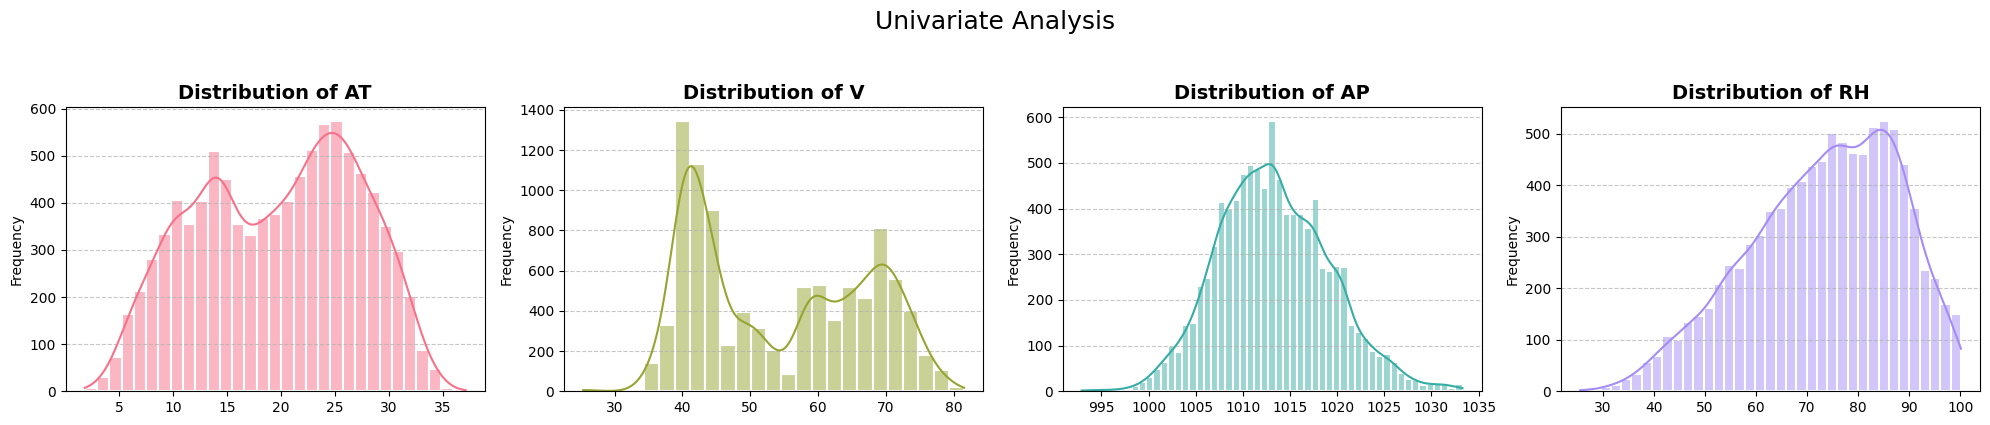

In [6]:
# features histograms
n_cols = 4
n_rows = 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

colors = sns.color_palette("husl", len(X.columns))

for i, col in enumerate(X.columns):
    sns.histplot(data=X, x=col, kde=True, color=colors[i], edgecolor="white", linewidth=1.5, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel(None)
    axes[i].set_ylabel("Frequency")
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

fig.suptitle("Univariate Analysis", fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

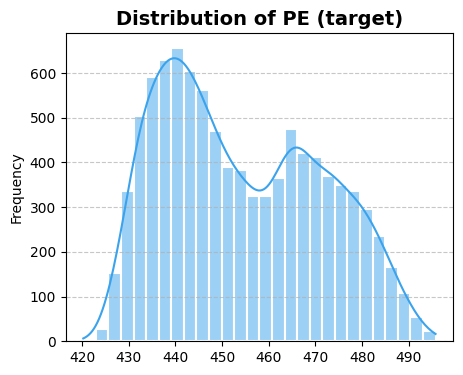

In [7]:
#target histogram

fig, ax = plt.subplots(figsize=(5, 4))
sns.histplot(data=y, x='PE', kde=True, color="#3ba3ec", edgecolor="white", linewidth=1.5, ax=ax)

ax.set_title("Distribution of PE (target)", fontsize=14, fontweight='bold')
ax.set_xlabel(None)
ax.set_ylabel("Frequency")
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

*Univariate Analysis*

The univariate analysis indicates that the distribution of the ambient temperature and vacuum pressure displays a bi-modal distribution. Since the former is an environmental condition, this might be due to the different temperatures corresponding to the seasonal variations while the vacuum data might be implying two different working modes. On the other hand, the pressure and humidity distribution show an approximately normal distribution. The power electric generation, target  variable, exhibits data around two different values, suggesting two different working conditions. This might be in connection to the seasons.

### Bivariate Analysis


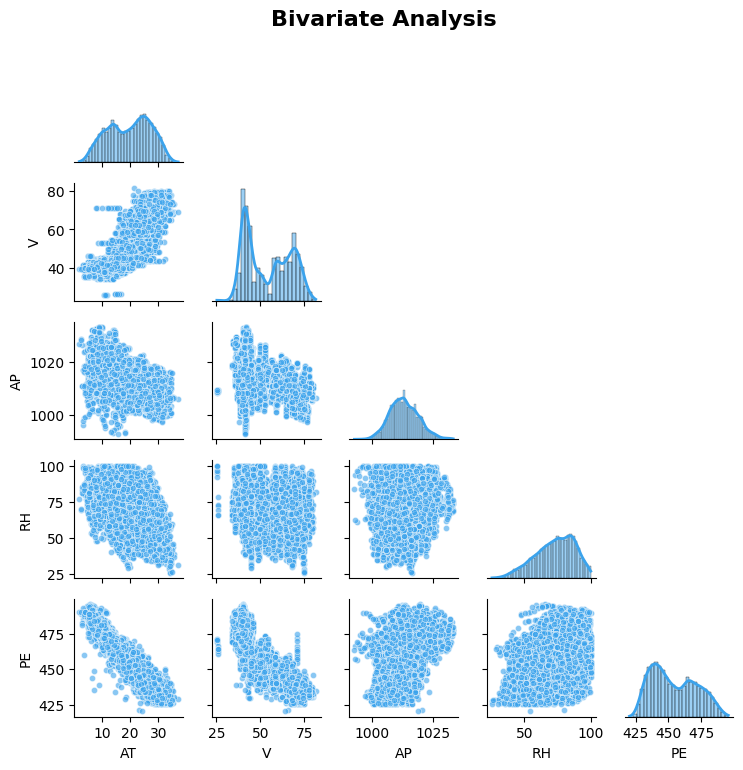

In [8]:
# pair plot graph

all_data_set = pd.concat([X, y], axis=1)

pair_plot_graph = sns.PairGrid(all_data_set, corner=True, height=1.5, aspect=1)
pair_plot_graph.map_lower(sns.scatterplot, color="#3ba3ec", s=20, alpha=0.6, edgecolor="white", linewidth=0.5)
pair_plot_graph.map_diag(sns.histplot, color="#3ba3ec", kde=True, line_kws={'linewidth': 2})
pair_plot_graph.fig.suptitle("Bivariate Analysis", fontsize=16, fontweight='bold', y=1.02)
plt.show()



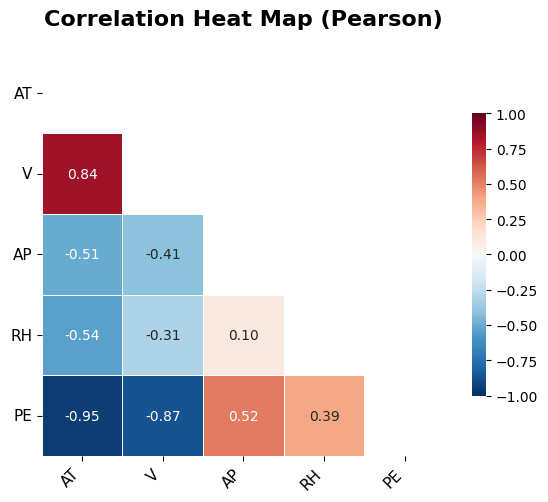

In [9]:
# correlation heat map

plt.figure(figsize=(6, 5))

corr_matrix = all_data_set.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
heatmap = sns.heatmap( corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='RdBu_r',vmin=-1, vmax=1, center=0, square=True, linewidths=.5,cbar_kws={"shrink": .7})

plt.title("Correlation Heat Map (Pearson)", fontsize=16, fontweight='bold', pad=20)
plt.xticks(fontsize=11, rotation=45, ha='right')
plt.yticks(fontsize=11, rotation=0)

plt.tight_layout()
plt.show()

*Bivariate Analysis*

The bivariate analysis reveals through the pair plot and correlation heat map a strong negative correlation of the power plant energy with ambient temperature and vacuum. The ambient pressure and humidity have a moderate positive influence on the target variable. Moreover, a strong positive link is observed between the ambient temperature and the vacuum. There is also a logical relationship between the environmental temperature, pressure and humidity consistent with physical laws.   

## 3. Data Preprocessing & Split

In [10]:
# new column to indicate an excessive saturation
X["rain_signal"]=((X["RH"])>100).astype(int)

In [11]:
# clip the RH column to 100%
X["RH"]=X["RH"].clip(upper=100)
# check the modifications
#print(X.describe())

In [12]:
# data splitting
train_X,test_X, train_y, test_y=train_test_split(X,y,random_state=1)

train_y=train_y.values.ravel()
test_y=test_y.values.ravel()

## 4. Model Training (Random Forest)

In [13]:
# model definition
CCPP_model=RandomForestRegressor(random_state=1)

In [14]:
# model training
CCPP_model.fit(train_X,train_y)

RandomForestRegressor(random_state=1)

In [15]:
# model predictions
preds=CCPP_model.predict(test_X)

In [16]:
# model quality measure
mae=mean_absolute_error(test_y,preds)
print(f"The random forests model has a mae of {mae:.2f}.")

The random forests model has a mae of 2.36.


In [17]:
error_porcentual=(mae*100/test_y.mean()).item()
print(f"The random forest model has a relative error of {error_porcentual:.2f} % .")

The random forest model has a relative error of 0.52 % .


### Hyperparameter Tuning

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


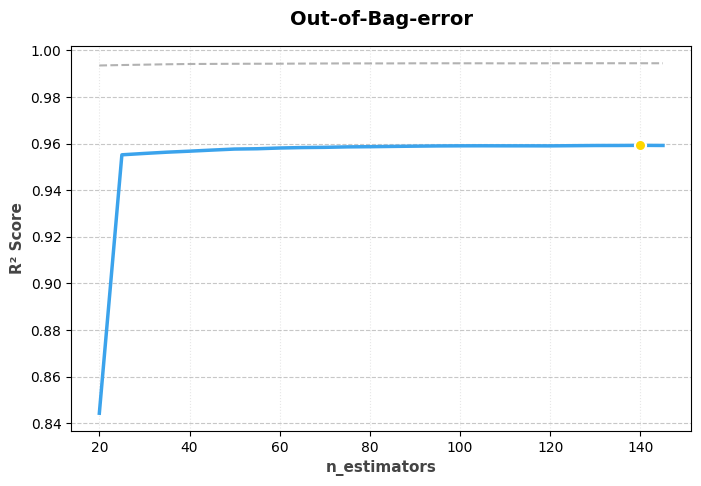

optimal value for n_estimators: 140
maximum score reached: 0.9592


In [18]:
# number of trees optimization using Out-of-Bag error validation

# variable generation
train_scores = []
oob_scores   = []

# values to evaluate
estimator_range = range(20, 150, 5)

# loop for training the model with estimator_range values
for n_estimators in estimator_range:
    model_tuning = RandomForestRegressor(n_estimators = n_estimators, oob_score=True, random_state = 1)
    model_tuning.fit(train_X, train_y)
    train_scores.append(model_tuning.score(train_X, train_y))
    oob_scores.append(model_tuning.oob_score_)

# errors figure
fig, ax = plt.subplots(figsize=(8, 5))
# colors definition
color_train = 'grey'
color_oob = '#3ba3ec'
color_max = '#FFD700'

# plots
ax.plot(estimator_range, train_scores, label="Train scores",
        color=color_train, linestyle='--', linewidth=1.5, alpha=0.6)
ax.plot(estimator_range, oob_scores, label="Out-of-Bag scores",
        color=color_oob, linewidth=2.5)
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores), marker='o', color=color_max,
        markersize=8, markeredgecolor='white', markeredgewidth=1.5,
        label="Max Score", zorder=5)

ax.set_ylabel("R² Score", fontsize=11, fontweight='bold', color='#444444')
ax.set_xlabel("n_estimators", fontsize=11, fontweight='bold', color='#444444')
ax.set_title("Out-of-Bag-error", fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.grid(axis='x', linestyle=':', alpha=0.3)

plt.show()

print(f"optimal value for n_estimators: {estimator_range[np.argmax(oob_scores)]}")
print(f"maximum score reached: {max(oob_scores):.4f}")

The figure indicates that the maximum score is achieved at n_estimators = 140. However, the R^2 score begins to plateau at 25. Therefore, we selected a value of 40 as a conservative threshold to optimize efficiency without compromising accuracy.

Note: The determination of the optimal n_estimator value was performed through the Out-of-Bag (OOB) error estimation on the training set in order to preserve the test set for the final independent performance evaluation.

## 5. Model Evaluation & Performance

In [19]:
# model with the optimun number of trees
CCPP_model=RandomForestRegressor(random_state=1, n_estimators=40)
# model training
CCPP_model.fit(train_X,train_y)
# value predictions
preds=CCPP_model.predict(test_X)
# model quality
mae=mean_absolute_error(test_y,preds)
print(f"The random forest model has a mae of {mae:.2f}.")
error_porcentual=(mae*100/test_y.mean()).item()
print(f"The random forest model has a relative error of  {error_porcentual:.2f} %.")

The random forest model has a mae of 2.38.
The random forest model has a relative error of  0.52 %.


###Feature Importance

In [20]:
#feature importances

importances = CCPP_model.feature_importances_

feature_names = train_X.columns

features_imp = pd.DataFrame({'Variable': feature_names, 'Importance': importances})
features_imp = features_imp.sort_values('Importance', ascending=False)

In [21]:
#table of feature importances
print(features_imp)

      Variable  Importance
0           AT    0.907577
1            V    0.054618
2           AP    0.019759
3           RH    0.018026
4  rain_signal    0.000020


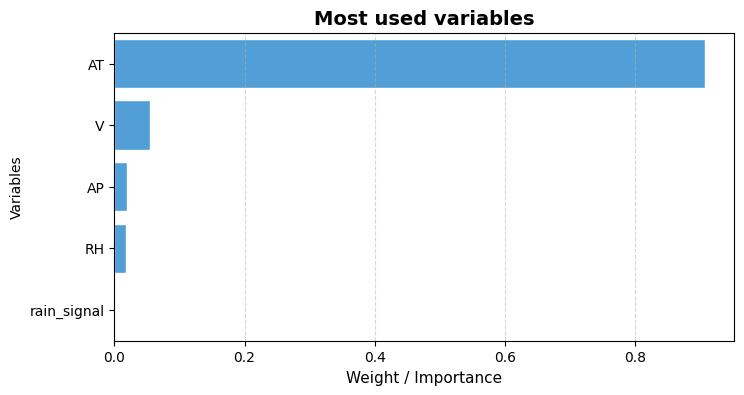

In [22]:
#plot
plt.figure(figsize=(8, 4))

sns.barplot( data=features_imp, x='Importance', y='Variable', color='#3ba3ec', edgecolor='white')

plt.title("Most used variables", fontsize=14, fontweight='bold')
plt.xlabel("Weight / Importance", fontsize=11)
plt.ylabel("Variables")
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

*Feature Importance Analysis*

The Feature Importance Analysis highlights the Ambient Temperature (AT) as the dominant predictor in the model contributing ≈91% to the model's predictive power. This is in good agreement with the system thermodynamics since gas turbines are more efficient when inlet air is cooler.  
Vacuum (V) achieved in the steam turbines is the next most influential factor (≈5%), reflecting its critical role in the steam turbine's performance.
In contrast, Atmospheric Pressure (AP) and Relative Humidity (RH) of the air inlet to the gas turbines show minor impact (combined ≈4%).
Finally, the Rain Signal variable introduced to the dataset has negligible importance (<0.002%) indicating that the original variable Relative Humidity was sufficient for the model.   

### Performance Evaluation

Final Results:
R² Score: 0.9637
RMSE: 3.28 MW / NRMSE: 0.72 %


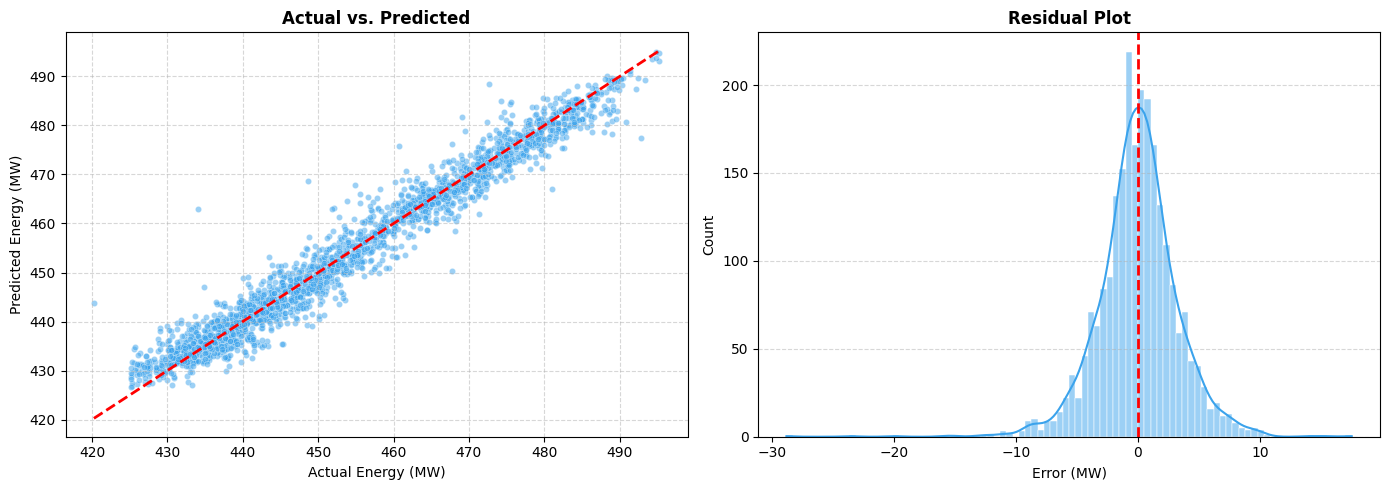

In [23]:
rmse = np.sqrt(mean_squared_error(test_y, preds))
nrmse=rmse*100/test_y.mean()
r2 = r2_score(test_y, preds)

print(f"Final Results:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f} MW / NRMSE: {nrmse:.2f} %")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs. Predicted figure
sns.scatterplot(x=test_y, y=preds, ax=axes[0], color='#3ba3ec', alpha=0.5, s=20)
axes[0].plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'r--', lw=2)
axes[0].set_title("Actual vs. Predicted", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Actual Energy (MW)")
axes[0].set_ylabel("Predicted Energy (MW)")
axes[0].grid(True, linestyle='--', alpha=0.5)

# Residual Plot
residue = test_y - preds
sns.histplot(residue, kde=True, ax=axes[1], color='#3ba3ec', edgecolor='white')
axes[1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1].set_title("Residual Plot", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Error (MW)")
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

*Performance Evaluation*

The final results reveal an R^2 value higher than 0.95, which indicates that the model successfully captures over 95% of the variability in the target variable.
The Root Mean Squared Error (RMSE) is 3.28 MW, indicating that the predicted values have an average deviation of +/- 3.28 MW. The Normalized Root Mean Squared Error (NRMSE) shows that this represents an error of just 0.72% relative to the average energy value.
The Actual vs. Predicted figure indicates that the values are distributed around the 45-degree line with no discernible pattern. Additionally, the Residual Plot shows a Gaussian distribution of the errors centered at zero. These two figures confirm the model's accuracy and the absence of systematic bias.

## 6. Conclusions

The Random Forest Regressor model achieved a Coefficient of Determination (R^2) of 0.96 on the test set, demonstrating a robust predictive capacity.

Feature importance analysis identified Ambient Temperature as the dominant predictor, followed by Vacuum (V). This finding aligns with thermodynamic principles, where cycle efficiency is inversely proportional to ambient temperature.

Furthermore, the model effectively captured the non-linear interactions among the features identified in the Exploratory Data Analysis.

Consequently, this model serves as a reliable tool for predicting the electrical output of a Combined Cycle Power Plant under varying environmental conditions.  